In [1]:
from Bio import AlignIO
import pandas as pd
import numpy as np

In [2]:
SEED=25

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import f1_score, log_loss, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (7,7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

In [3]:
# Extracting sequences as multiple alignments into a numpy array 
alignment = AlignIO.read('aligned ireds.clustal', 'clustal')
align_array = np.array([list(rec) for rec in alignment], np.dtype(np.str_))
print('Array shape %i by %i' % align_array.shape)

Array shape 383 by 1000


In [4]:
# Extracting IRED number from alignments, ready to assign to index in dataframe
align_index = AlignIO.read('aligned ireds.clustal', 'clustal')
ired_names = []
for record in align_index:
    ired_names.append(record.id)

In [5]:
# Creating a dictionary of the z5 metrics plus another dimension (binary) which distinguishes between AA and gaps
z5_dict = {
    'A': [0.24, -2.32, 0.60, -0.14, 1.30],
    'R': [3.52, 2.50, -3.50, 1.99, -0.17],
    'N': [3.05, 1.62, 1.04, -1.15, 1.61],
    'D': [3.98, 0.93, 1.93, -2.46, 0.75],
    'C': [0.84, -1.67, 3.71, 0.18, -2.65],
    'Q': [1.75, 0.50, -1.44, -1.34, 0.66],
    'E': [3.11, 0.26, -0.11, -3.04, -0.25],
    'G': [2.05, -4.06, 0.36, -0.82, -0.38],
    'H': [2.47, 1.95, 0.26, 3.90, 0.09],
    'I': [-3.89, -1.73, -1.71, -0.84, 0.26],
    'L': [-4.28, -1.30, -1.49, -0.72, 0.84],
    'K': [2.29, 0.89, -2.49, 1.49, 0.31],
    'M': [-2.85, -0.22, 0.47, 1.94, -0.98],
    'F': [-4.22, 1.94, 1.06, 0.54, -0.62],
    'P': [-1.66, 0.27, 1.84, 0.70, 2.00],
    'S': [2.39, -1.07, 1.15, -1.39, 0.67],
    'T': [0.75, -2.18, -1.12, -1.46, -0.40],
    'W': [-4.36, 3.94, 0.59, 3.44, -1.59],
    'Y': [-2.54, 2.44, 0.43, 0.04, -1.47],
    'V': [-2.59, -2.64, -1.54, -0.85, -0.02],
    '-': [0.0, 0.0, 0.0, 0.0, 0.0],
    '*': [0.0, 0.0, 0.0, 0.0, 0.0]
}

In [6]:
feat_seqs = {}
for i, sequence in enumerate(align_array):
    single_feat = []
    for aa in sequence:
        indices = z5_dict.get(aa)
        single_feat.extend(indices)
    feat_seqs[ired_names[i]] = single_feat

In [7]:
df_ee = pd.read_excel('Prelim data.xlsx', engine='openpyxl')

In [8]:
df_ee.dropna(subset=['Enantiomer'], inplace=True)
df_ee.head(2)
df_ee.shape

(206, 6)

In [9]:
labels = {}
for index, row in df_ee.iterrows():
    labels[str(row['IRED No. '])] = row['enantiomer binary']

In [10]:
enantiomer_list = []
descrip_list = []
for ired_name in labels:
    enantiomer_list.append(labels.get(ired_name))
    descrip_list.append(feat_seqs.get(ired_name))

In [11]:
X = descrip_list
y = enantiomer_list 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=SEED)

# k-Nearest Neighbours (k-NN)

In [13]:
# Fitting model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Metric evaluation
y_pred = knn.predict(X_test)
knn_accuracy = knn.score(X_test, y_test)
knn_f1 = f1_score(y_test, y_pred)
knn_logloss = log_loss(y_test, y_pred)
y_scores = knn.predict_proba(X_test)
knn_roc_auc = roc_auc_score(y_test, y_scores[:,1])

# Cross-validation
knn_cv = cross_val_score(knn, X, y, cv=10, scoring='f1')
knn_cv_mean = knn_cv.mean()
knn_cv_std = knn_cv.std()

knn = {'knn': [knn_accuracy, knn_f1, knn_logloss, knn_roc_auc, knn_cv_mean]}
results_df = pd.DataFrame(knn, index=['Accuaracy', 'F1 score', 'Log Loss', 'ROC-AUC score', 
                  'Cross-validation (F1 score) mean'])

# Logistic Regression

In [14]:
logreg = LogisticRegression(solver='saga')
logreg.fit(X_train, y_train)

# Metric evaluation
y_pred = logreg.predict(X_test)
logreg_accuracy = logreg.score(X_test, y_test)
logreg_f1 = f1_score(y_test, y_pred)
logreg_logloss = log_loss(y_test, y_pred)
y_scores = logreg.predict_proba(X_test)
logreg_roc_auc = roc_auc_score(y_test, y_scores[:,1])

# Cross-validation
logreg_cv = cross_val_score(logreg, X, y, cv=10, scoring='f1')
logreg_cv_mean = logreg_cv.mean()
logreg_cv_std = logreg_cv.std()

logreg = [logreg_accuracy, logreg_f1, logreg_logloss, logreg_roc_auc, logreg_cv_mean]

results_df['Logistic Regression'] = logreg

/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/a

# Voting Classifier Ensemble

In [15]:
lr = LogisticRegression(random_state=SEED, solver='saga')
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=SEED)
classifiers = [('Logistic Regression', lr),('K Nearest Neighbours', knn),('Classification Tree', dt)]

## Soft voting

In [16]:
vc_soft = VotingClassifier(estimators=classifiers, voting='soft')
vc_soft.fit(X_train, y_train)

# Metric evaluation
y_pred = vc_soft.predict(X_test)
vc_soft_accuracy = vc_soft.score(X_test, y_test)
vc_soft_f1 = f1_score(y_test, y_pred)
vc_soft_logloss = log_loss(y_test, y_pred)
y_scores = vc_soft.predict_proba(X_test)
vc_soft_roc_auc = roc_auc_score(y_test, y_scores[:,1])

# Cross-validation
vc_soft_cv = cross_val_score(vc_soft, X, y, cv=10, scoring='f1')
vc_soft_cv_mean = vc_soft_cv.mean()
vc_soft_cv_std = vc_soft_cv.std()

vc_soft = [vc_soft_accuracy, vc_soft_f1, vc_soft_logloss, vc_soft_roc_auc, vc_soft_cv_mean]

results_df['Voting Classifier - soft'] = vc_soft

/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/a

## Hard voting

In [17]:
vc_hard = VotingClassifier(estimators=classifiers, voting='hard')
vc_hard.fit(X_train, y_train)

# Metric evaluation
y_pred = vc_hard.predict(X_test)
vc_hard_accuracy = vc_hard.score(X_test, y_test)
vc_hard_f1 = f1_score(y_test, y_pred)
vc_hard_logloss = log_loss(y_test, y_pred)

# Cross-validation
vc_hard_cv = cross_val_score(vc_hard, X, y, cv=10, scoring='f1')
vc_hard_cv_mean = vc_hard_cv.mean()
vc_hard_cv_std = vc_hard_cv.std()

vc_hard = [vc_hard_accuracy, vc_hard_f1, vc_hard_logloss, 'N/a', vc_hard_cv_mean]

results_df['Voting Classifier - hard'] = vc_hard

/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/anaconda3/envs/Bioembeddings/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/Tom/opt/a

# Bagging Classifier

In [18]:
dt_bag = DecisionTreeClassifier(max_depth=4, min_samples_leaf=0.16, random_state=SEED)
bc = BaggingClassifier(dt_bag, n_estimators=300, n_jobs=-1)
bc.fit(X_train, y_train)

# Metric evaluation
y_pred = bc.predict(X_test)
bc_accuracy = bc.score(X_test, y_test)
bc_f1 = f1_score(y_test, y_pred)
bc_logloss = log_loss(y_test, y_pred)
y_scores = bc.predict_proba(X_test)
bc_roc_auc = roc_auc_score(y_test, y_scores[:,1])

# Cross-validation
bc_cv = cross_val_score(bc, X, y, cv=10, scoring='f1')
bc_cv_mean = bc_cv.mean()
bc_cv_std = bc_cv.std()

bc = [bc_accuracy, bc_f1, bc_logloss, bc_roc_auc, bc_cv_mean]

results_df['Bagging classifier'] = bc

# XGBoosting

## Data manipulation, fitting, evaluation (accuracy, f1, log loss)

In [19]:
import xgboost as xgb

X_trainNPArray = np.array(X_train); X_testNPArray = np.array(X_test)
y_trainNPArray = np.array(y_train); y_testNPArray = np.array(y_test)

X_train_xgb = np.vstack(X_trainNPArray); X_test_xgb = np.vstack(X_testNPArray)
y_train_xgb = np.vstack(y_trainNPArray); y_test_xgb = np.vstack(y_testNPArray)

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=SEED, use_label_encoder=False)

xgb_model.fit(X_train_xgb,y_train_xgb)

# Model evaluation
y_pred_xgb = xgb_model.predict(X_test_xgb)
xgb_accuracy = xgb_model.score(X_test_xgb, y_test_xgb)
xgb_f1 = f1_score(y_testNPArray, y_pred_xgb)
xgb_logloss = log_loss(y_test_xgb, y_pred_xgb)
y_scores = xgb_model.predict_proba(X_test_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_scores[:,1])

# Cross-validation
xgb_cv = cross_val_score(xgb_model, np.vstack(X), np.vstack(y), cv=10, scoring='f1')
xgb_cv_mean = xgb_cv.mean()
xgb_cv_std = xgb_cv.std()

xgb_model = [xgb_accuracy, xgb_f1, xgb_logloss, xgb_roc_auc, xgb_cv_mean]

results_df['XGBoost (sklearn API)'] = xgb_model

[10:04:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607

## DataFrame of results

In [20]:
results_df

,knn,Logistic Regression,Voting Classifier - soft,Voting Classifier - hard,Bagging classifier,XGBoost (sklearn API)
Accuaracy,0.807692,0.826923,0.846154,0.826923,0.846154,0.846154
F1 score,0.880952,0.891566,0.902439,0.888889,0.906977,0.902439
Log Loss,6.642195,5.977973,5.313750,5.977957,5.313781,5.313750
ROC-AUC score,0.760355,0.745562,0.741617,N/a,0.698225,0.729783
Cross-validation (F1 score) mean,0.875604,0.894271,0.888284,0.895497,0.884147,0.882455


In [21]:
df_ee.reset_index(inplace=True)
df_ee.head()

,index,IRED No.,Reaction 2,ee,Enantiomer,enantiomer binary,Sequence
0,0,1,"62% (33% ee, S)",33.0,S,1.0,MSTKKVTVIGLGSLGSALAAALLRTGHDVTVWNRTPEKAEALVAQG...
1,1,2,"67% (46% ee, S)",46.0,S,1.0,MTDTSAKLTLLGLGAMGSALATAWLAADYDITVWNRTASRAEPLRT...
2,2,3,"36%, (35% ee, S)",35.0,S,1.0,MSKHISIFGLGAMGAALAARYLEHGYKTTVWNRTTAKATPLVEQGA...
3,3,4,"97% (35% ee, S)",35.0,S,1.0,MSTITLFGLGAMGKALAAKYIEKGYTTTIWNRTPSKAAPLVEKGAK...
4,5,6,"99% (75% ee, S)",75.0,S,1.0,MPESTTPSTATPVTIIGLGAMGTALANAFLDAGHSTTVWNRTAARA...


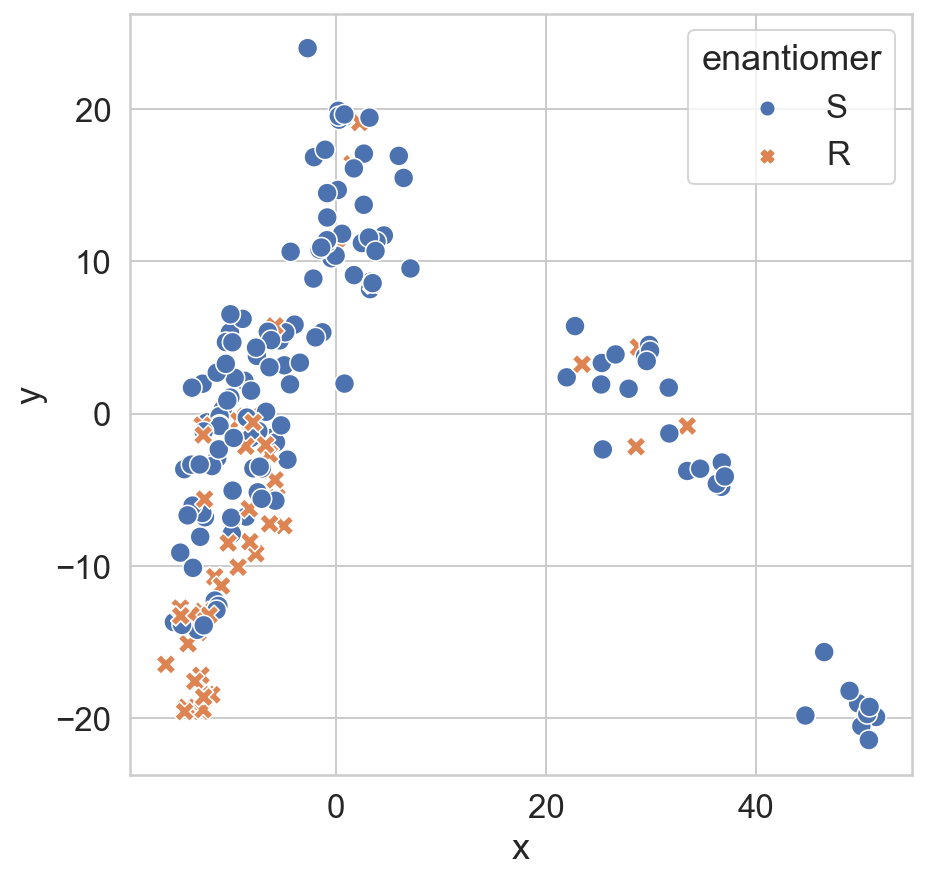

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
crds = pca.fit_transform(X)

pca_df = pd.DataFrame(crds, columns=['x', 'y'])

y = df_ee['Enantiomer']

enantiomer_column = []
for i in list(range(0,206)):
    enantiomer_column.append(y[i])
pca_df['enantiomer'] = enantiomer_column

ax = sns.scatterplot(data=pca_df, x='x', y='y', hue='enantiomer', style='enantiomer', s=100)
fig = ax.get_figure()
fig.savefig("ZScales PCA.png") 

In [54]:
# Creating a dictionary of x coordinates and IRED no. to collect IREDs from the two disctint clusters
x_crds = (crds[:,0]).tolist()
ired_no = list(df_ee['IRED No. '])
x_crds_dict = dict(zip(ired_no, x_crds))

In [61]:
bottom_cluster = []
for key, value in x_crds_dict.items():
    if  value >= 40:
        bottom_cluster.append(key)

bottom_cluster

[11, 25, 31, 51, 52, 54, 56, 57, 66]

In [59]:
middle_cluster = []
for key, value in x_crds_dict.items():
    if 20 <= value <= 40:
        middle_cluster.append(key)

middle_cluster

[60,
 69,
 70,
 72,
 98,
 99,
 111,
 127,
 149,
 150,
 162,
 169,
 175,
 190,
 194,
 198,
 213,
 218,
 219,
 225,
 312,
 347,
 348,
 377]

In [62]:
len(middle_cluster)

24

In [133]:
pca_df['IRED no.'] = df_ee['IRED No. ']
pca_df.set_index('IRED no.', inplace=True)
pca_df.head()

,x,y,enantiomer
IRED no.,,,
1,-7.970371,-4.047470,S
2,-5.050165,2.515309,S
3,-8.817475,1.566695,S
4,-7.729177,3.765733,S
6,-13.075758,-6.685261,S


In [70]:
# Creating a 2D numpy array of actual and predicted (by XGBoost model) values
predictions = np.column_stack((y_test, y_pred_xgb))

# Comparing outcome vs prediction, True if correct, False if incorrect prediction by XGBoost model
outcomes = np.equal(predictions[:,0], predictions[:,1])

In [89]:
# Creating a list of the IRED nos for enzymes used in the test set
ired_test_no = []
for ired_seq in X_test:
    for key, value in feat_seqs.items():
        if ired_seq == value:
            ired_test_no.append(key)
            break

In [90]:
# Creating a dictionary of IREDs used in the test set and outcome of prediction
test_outcomes = dict(zip(ired_test_no, outcomes))

In [164]:
# Generating a list to add into the pca_df dataframe which contains the predicted vs actual outcome, or if it
# was not tested.
test_results = []
for index, row in pca_df.iterrows():
    if str(index) in test_outcomes:
        test_results.append(test_outcomes[str(index)])
    else:
        test_results.append('Not tested')

In [176]:
pca_df['test results'] = test_results
pca_df.head()

,x,y,enantiomer,test results
0,-7.970350,-4.051655,S,Not tested
1,-5.050181,2.516608,S,Not tested
2,-8.817475,1.574283,S,True
3,-7.729179,3.772491,S,Not tested
4,-13.075749,-6.688154,S,Not tested


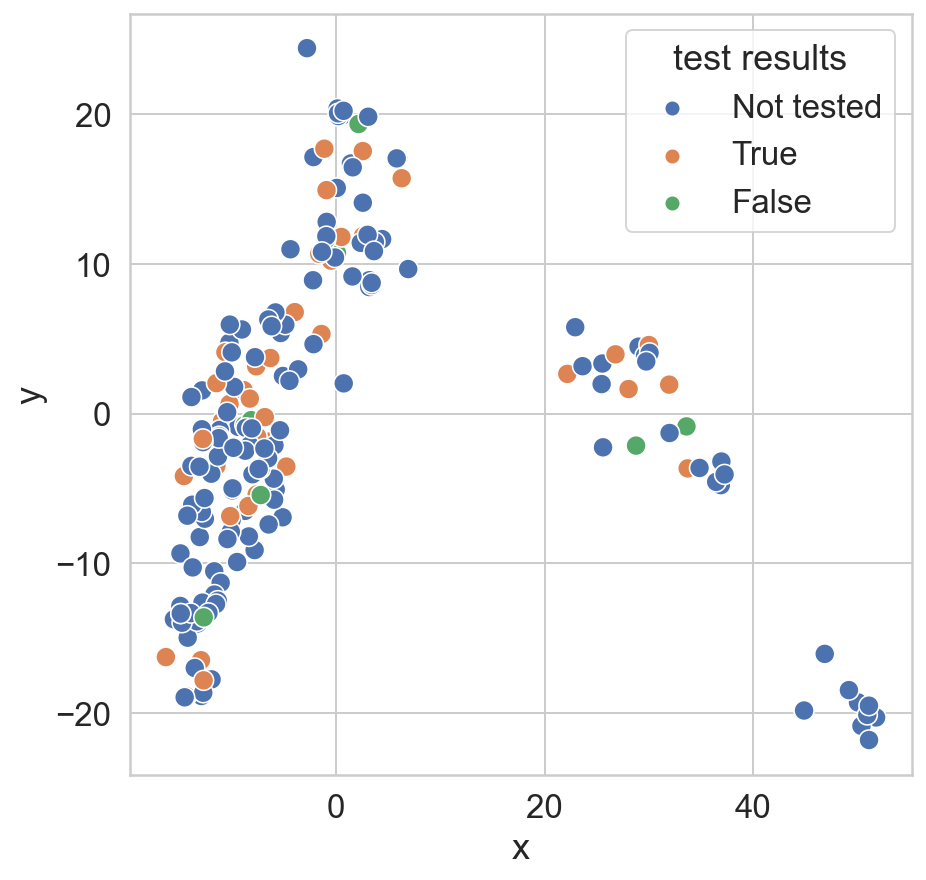

In [177]:
ax = sns.scatterplot(data=pca_df, x='x', y='y', hue='test results', s=100)
fig = ax.get_figure()
fig.savefig("Test results.png") 